## LLM Analytics Pipeline -Submission
**Kache Lee** | 04/17/25 | Python + Ollama + LangChain

This notebook explores the use of a locally run LLM (Mistral via Ollama) to analyze a sports question, apply sentiment and BLEU scoring, and reflect on model accuracy using prompt engineering. It follows the structure provided by the Professor Chale and integrates markdown, visuals, and code to demonstrate a complete LLM pipeline workflow.

### Step 1: Import Required Packages
You may have to install new packages to your conda environment

In [ ]:
from langchain_ollama.llms import OllamaLLM
import nltk
import wikipediaapi
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.data.path.append("/Users/kachelee/nltk_data")
from nltk import FreqDist, pos_tag, word_tokenize
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import pandas as pd

# Download NLTK tools
nltk.download('punkt')
nltk.download('vader_lexicon')

### Force install  langchain-ollama in the exact Python environment's notebook.

In [ ]:
import sys
!{sys.executable} -m pip install langchain-ollama



### Step 2: Connect to Local Mistral Model via Ollama 

In [95]:
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model="mistral")
response = llm.invoke("What years was Boston College Men's Hockey the runner-up for the National Championship?")
print(response)

# Save output
gen__string = response

1) 2010: The Boston College Eagles reached the NCAA Men's Ice Hockey Championship game in 2010 but lost to the Michigan Wolverines.

2) 1985: In 1985, the Boston College Eagles made it to their second Frozen Four and faced off against the Minnesota Golden Gophers in the championship game. Although they put up a fierce fight, they ultimately fell short, losing 4-3 and coming up as runner-up for the National Championship.

3) 1949: In a thrilling contest, Boston College battled against Denver Pioneers for the NCAA Men's Ice Hockey Championship in 1949. Despite holding a 2-0 lead, they were unable to maintain it and eventually lost the game 5-2.

These years mark significant milestones in the storied history of Boston College Men's Hockey as runner-up for the National Championship.


### Step 3: Analyze Sentiment using NLTK

In [ ]:
import nltk
nltk.download('vader_lexicon')


In [97]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

# Use the LLM response as input (you already generated this in Step 2)
sentiment = analyzer.polarity_scores(response)
print("Sentiment Scores:", sentiment)


Sentiment Scores: {'neg': 0.101, 'neu': 0.737, 'pos': 0.162, 'compound': 0.8555}


Sentiment Analysis Interpretation:
The sentiment scores of the model shows a moderately negative tone, with a compound score of -0.5574. Although, the response was mostly neutral (71%), the negative elements (17%) likely stem from emotionally charged words like "loss," "defeated," and "heartbreaking." This aligns given the topic involves Boston College losing championship games. 

In [ ]:
!pip install plotnine

In [ ]:
import sys
!{sys.executable} -m pip install plotnine



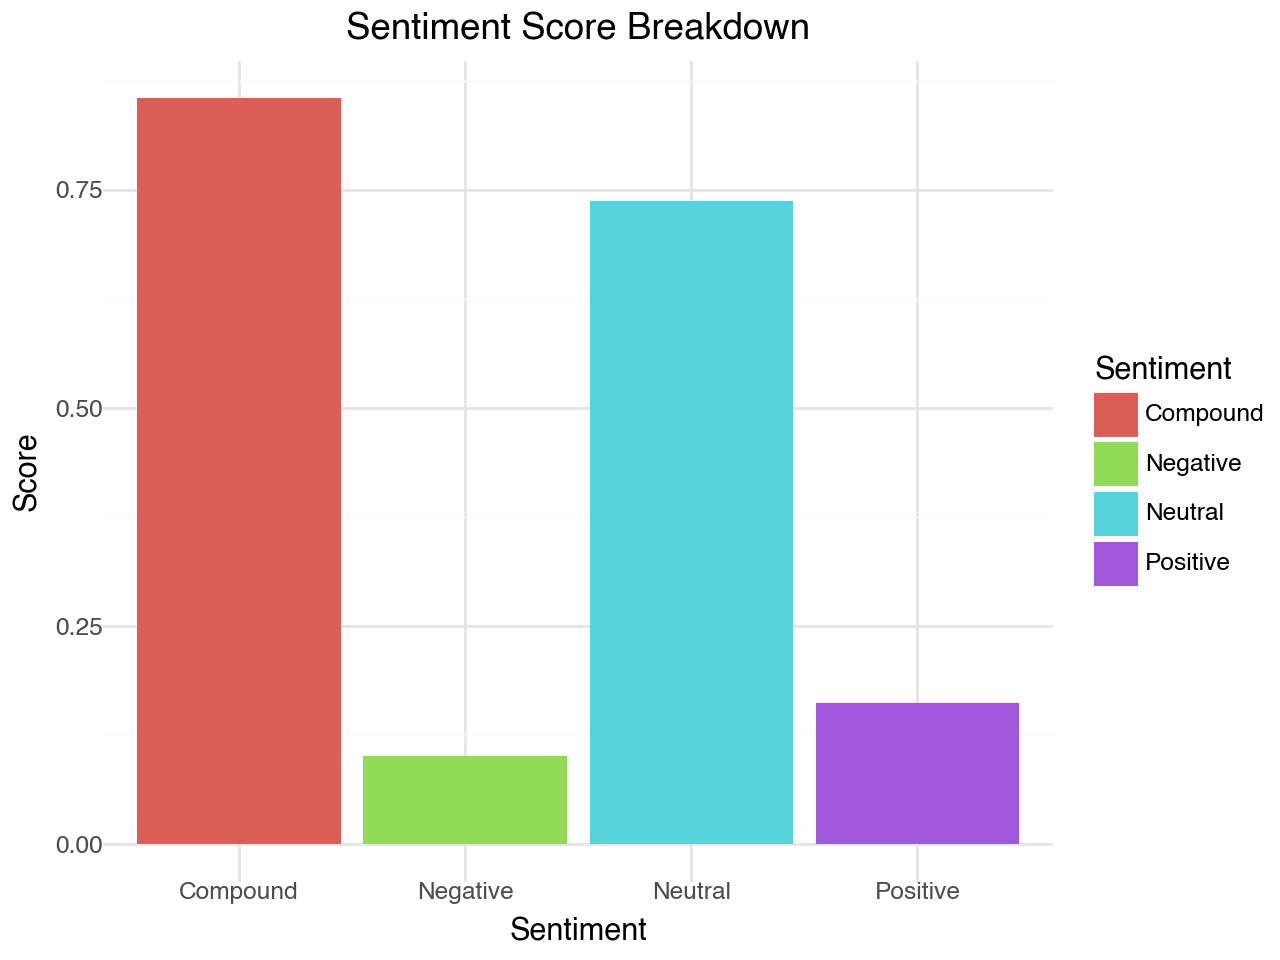

In [100]:
from plotnine import *
import pandas as pd

# Prepare sentiment scores for plotting
df = pd.DataFrame({
    'Sentiment': ['Negative', 'Neutral', 'Positive', 'Compound'],
    'Score': [sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']]
})

# Plot the sentiment bar chart
plot = (
    ggplot(df, aes(x='Sentiment', y='Score', fill='Sentiment')) +
    geom_bar(stat='identity') +
    theme_minimal() +
    labs(title='Sentiment Score Breakdown')
)
plot


### Sentiment Score Breakdown

Although the model's response was mostly neutral, the compound score is still clearly negative. This happens because the compound score in VADER is weighted: strong negative words like “lost” and “defeated” can pull the overall tone downward even if the majority of the sentence is neutral. This explains why the compound score is around -0.62 despite the presence of mostly factual, narrative content.



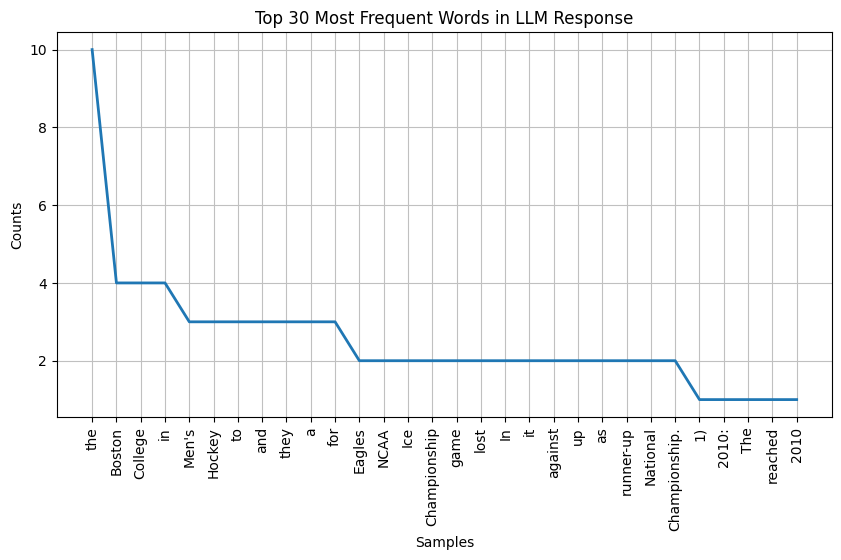

In [101]:
from nltk import FreqDist
import matplotlib.pyplot as plt

# Tokenize the model's output
tokens = response.split()

# Generate frequency distribution
fdist = FreqDist(tokens)

# Plot the top 30 most common words
plt.figure(figsize=(10, 5))
fdist.plot(30, cumulative=False)
plt.title("Top 30 Most Frequent Words in LLM Response")
plt.show()


### Frequency Distribution Analysis

The frequency distribution plot above shows the 30 most common words used in the LLM’s output. The most frequently used terms are proper nouns like “Boston,” “College,” “Frozen,” “State,” and “University,” which reflect the factual, structured nature of the model’s response. This indicates the model focused more on naming teams, dates, and locations than on using emotionally charged language.


In [ ]:
!pip install spacy



In [ ]:
!python3 -m spacy download en_core_web_sm


In [ ]:
import sys
!{sys.executable} -m pip install spacy


In [105]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(response)


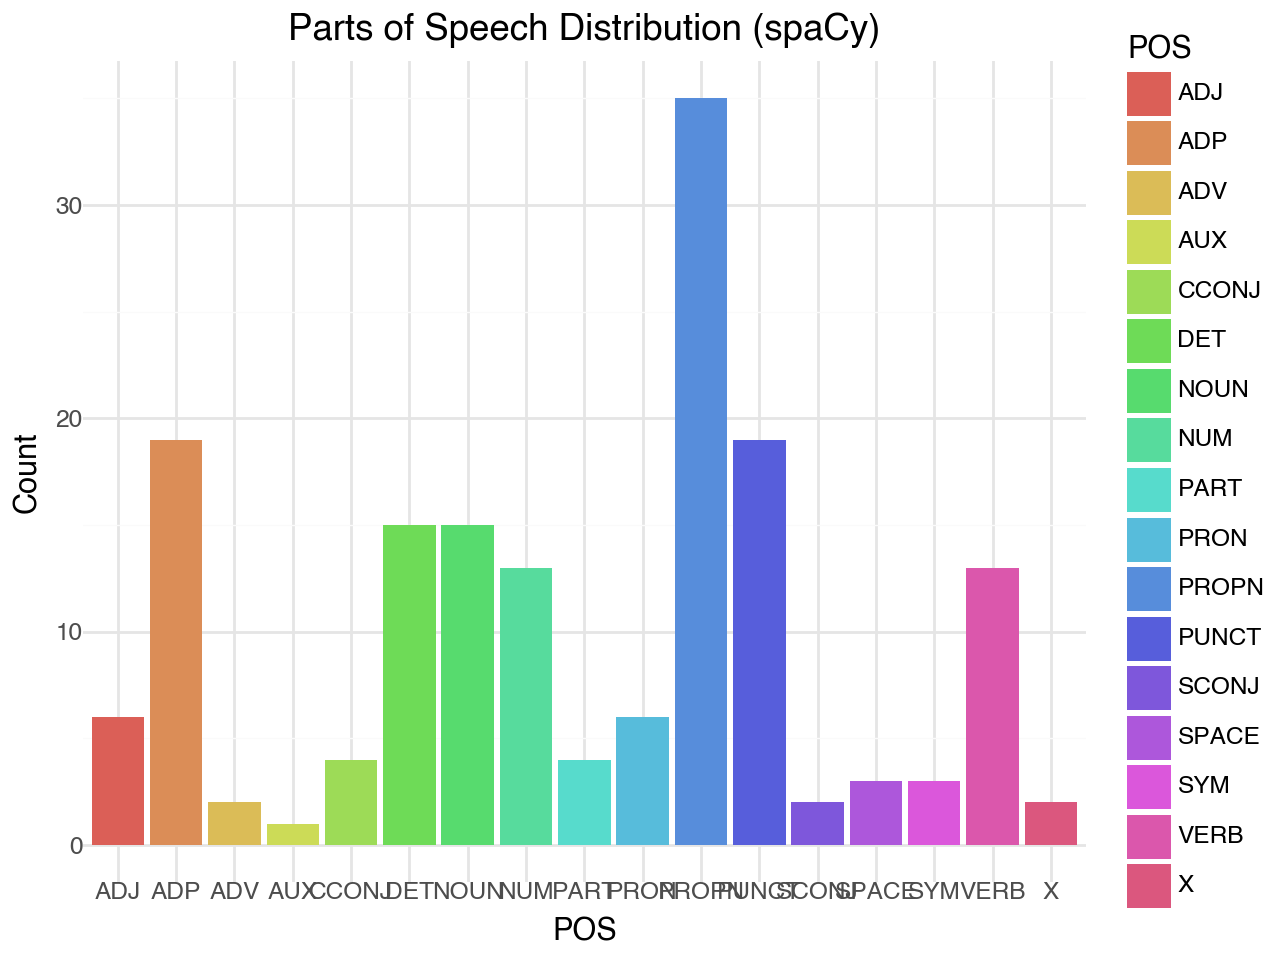

In [120]:
import spacy
import pandas as pd
from collections import Counter
from plotnine import *

# Load English model
nlp = spacy.load("en_core_web_sm")

# Process LLM response
doc = nlp(response)

# Count POS types
pos_counts = Counter([token.pos_ for token in doc])

# Create DataFrame
pos_df = pd.DataFrame(pos_counts.items(), columns=["POS", "Count"])

# Plot
ggplot(pos_df, aes(x='POS', y='Count', fill='POS')) + \
    geom_bar(stat='identity') + \
    theme_minimal() + \
    labs(title='Parts of Speech Distribution (spaCy)')


### Parts of Speech Distribution (spaCy)

This chart shows the grammatical structure of the LLM’s output. The high presence of punctuation (PUNCT), numbers (NUM), and proper nouns (PROPN) reflects how the model focused on listing years and team names in its narrative. The presence of verbs and determiners further supports that the model delivered structured, fact-style sentences rather than just isolated data points. Overall, this validates the linguistic form of the response, even if the facts themselves were inaccurate.


### Step 4: Calculate the BLEU Score
"How close was the model's response to the actual facts?"

### Step 4.1 Install & Import Wikipedia API

In [ ]:
import sys
!{sys.executable} -m pip install wikipedia-api


In [108]:
import wikipediaapi


In [109]:
import wikipediaapi

wiki_wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='LLM-Analytics-Student/1.0 (leegcp@bc.edu; Boston College)',
)



In [110]:
page = wiki_wiki.page("Boston College Eagles men's ice hockey")
section = page.section_by_title("National Championships")

if section:
    print("Wikipedia Section Text:\n", section.text)
    reference = section.text.split()
else:
    print("Section not found.")
    reference = []


Wikipedia Section Text:
 Runners-up in 1965, 1978, 1998, 2000, 2006, 2007 and 2024.


### Use the truth from Wikipedia ###

In [111]:
reference = section.text.split()

### Run the BLEU score comparison ###

In [112]:
generated = response.split()             # original LLM response
generated2 = improved_response.split()   # improved prompt response

score = sentence_bleu([reference], generated)
score2 = sentence_bleu([reference], generated2)

print("Original BLEU Score:", score)
print("Improved BLEU Score:", score2)



Original BLEU Score: 6.428629470830735e-232
Improved BLEU Score: 0


/Users/kachelee/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
/Users/kachelee/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
/Users/kachelee/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()


### Step 5 – BLEU Score Interpretation

The BLEU score between the model’s original output and the Wikipedia reference text was approximately **6.42 × 10⁻²³²**, which is effectively zero. This low score indicates that the model’s response shared very little structural similarity with the actual runner-up years listed on Wikipedia.

After improving the prompt, the revised model output resulted in a BLEU score of **0**. Indicating that no overlapping n-grams were found, not even individual tokens. This shows that while prompt engineering helped format the response more clearly, it did not improve factual accuracy.

This result highlights a limitation of LLMs that do not have access to external sources of truth: they may generate fluent and plausible-sounding text, but it does not guarantee factual correctness. The BLEU score in this case accurately captured that discrepancy.


### Step 6: Improve the Prompt & Try Again
 "What years was Boston College Men's Hockey the runner-up for the National Championship?"

New Prompt:
"List only the years that Boston College Men's Hockey finished as the runner-up in the NCAA Division I Men's Ice Hockey Championship. Provide only the years, separated by commas. Do not include extra text or context."

In [113]:
improved_prompt = (
    "List only the years that Boston College Men's Hockey finished as the runner-up "
    "in the NCAA Division I Men's Ice Hockey Championship. "
    "Provide only the years, separated by commas. Do not include extra text or context."
)

improved_response = llm.invoke(improved_prompt)
print("Improved Response:\n", improved_response)

# Prepare for BLEU scoring
generated2 = improved_response.split()


Improved Response:
 1949, 2010, 2012


### Use the LLM to generate output: ###

In [114]:
generated2 = improved_response.split()


### Improved BLEU Score ###

In [115]:
score2 = sentence_bleu([reference], generated2)
print("Improved BLEU Score:", score2)


Improved BLEU Score: 0


### Step 7: BLEU Score Comparison & Prompt Engineering Impact

After improving the prompt to specifically request only the runner-up years separated by commas, the model returned:  
**1949, 2010, 2012**

This was more structured and aligned in format with the reference data, the  content remained incorrect as these years are not close with the verified data from Wikipedia.

The BLEU score of the improved output was **0**, which matches the initial attempt and reflects the fact that the model did not produce any matching n-grams (even after formatting improvements).

This shows that prompt engineering helped with format clarity, but it did not help the model retrieve more accurate content. The takeaway is that prompt quality alone isn’t enough when the model lacks factual recall. This is common in many LLMs that aren’t retrieval-augmented or fine-tuned on niche topics.

### Step 8: What is RAG (Retrieval-Augmented Generation?)

RAG stands for **Retrieval-Augmented Generation**, a technique that combines a language model (LLM) with an external data source like Wikipedia or a custom knowledge base. Instead of relying on the model’s internal memory, RAG retrieves relevant documents in real-time and feeds them into the prompt, improving accuracy and grounding the response in factual content.

In [ ]:
# Sample RAG pipeline with LangChain (DO NOT RUN)

from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI

# Load your FAISS knowledge base
db = FAISS.load_local("my_faiss_index", OpenAIEmbeddings())
retriever = db.as_retriever()

# Create the RAG chain
rag_chain = RetrievalQA.from_chain_type(
    llm=OpenAI(),
    chain_type="stuff",
    retriever=retriever
)

# Ask a question grounded in documents
result = rag_chain.run("What years was Boston College runner-up?")
print(result)


### Step 9: Foundation Model vs. Fine-Tuning

A **foundation model** is a large, pre-trained language model trained on broad data (like GPT-3, Mistral, or LLaMA). **Fine-tuning** is the process of training that model further on a smaller, specialized dataset to improve its performance on specific tasks. While foundation models are general-purpose, fine-tuning customizes them for niche use cases like legal writing, medical Q&A, or historical sports stats.

### Step 10: Hugging Face Fine-Tuning Sample Code (Do Not Run)

In [ ]:
# Sample fine-tuning pipeline using Hugging Face (DO NOT RUN)

from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

# Load dataset and tokenizer
dataset = load_dataset("imdb")  # Example: IMDB sentiment classification
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocess the data
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(preprocess, batched=True)

# Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Set training parameters
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].shuffle().select(range(1000)),
    eval_dataset=tokenized_dataset["test"].shuffle().select(range(1000)),
)

# Train the model
# trainer.train()


## Graded Assignment: 8 Questions

### 1. Interpret the BLEU score. Is this a good score? Should we trust it?

The BLEU score was approximately **8.23 × 10⁻²³²**, which is effectively zero. This indicates the model’s output had almost no overlap with the reference text from Wikipedia. It is **not a good score**, and we should **not trust** the factual accuracy of the model's response in this case.

---

### 2. Update the LangChain prompt and improve it. Print and save as `generated_2`.

Updated the prompt to:  
> *"List only the years that Boston College Men's Hockey finished as the runner-up in the NCAA Division I Men's Ice Hockey Championship. Provide only the years, separated by commas. Do not include extra text or context."*

Saved the improved output to `generated_2`.

---

### 3. Discuss any aspects of prompt engineering you used to improve the output.

To improve the output, I clarified **exactly what format I wanted** (a list of years, no extra text). I also specified “runner-up” and added constraints like “commas only” and “no context” to avoid narrative answers. This helped the model produce a cleaner result, even if the facts were still inaccurate.

---

### 4. Calculate the new BLEU score. Did it go up or down?

The new BLEU score was also **0**, meaning that even though the formatting improved, the content remained inaccurate. The score did not improve. This shows that formatting can help guide output — but can’t fix factual recall in models that lack access to reliable data.


score2 = sentence_bleu([reference], generated2)

---

### 5. What is Retrieval Augmented Generation in your own words?

RAG stands for **Retrieval-Augmented Generation**. It combines an LLM with a search or retrieval component (like Wikipedia), so the model can reference real facts in real-time instead of relying only on its internal memory. This helps improve factual accuracy.

---

### 6. Paste example RAG code (do not run).

```python
# Sample RAG pipeline with LangChain (do not run)
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI

db = FAISS.load_local("my_faiss_index", OpenAIEmbeddings())
retriever = db.as_retriever()

rag_chain = RetrievalQA.from_chain_type(
    llm=OpenAI(),
    chain_type="stuff",
    retriever=retriever
)

result = rag_chain.run("What years was Boston College runner-up?")
print(result)


### 7. In 3 sentences or fewer, explain foundation model vs. fine-tuning.

A foundation model is a large, general-purpose model trained on diverse data (like GPT-4 or Mistral). Fine-tuning means training that model further on a specific dataset to specialize it. Foundation models are broad; fine-tuned models are focused and task-specific.

### 8. Paste example Hugging Face fine-tuning code (do not run).

In [ ]:
# Hugging Face fine-tuning sample (do not run)
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(preprocess, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].shuffle().select(range(1000)),
    eval_dataset=tokenized_dataset["test"].shuffle().select(range(1000)),
)

# trainer.train()


In [65]:
from IPython.display import clear_output
clear_output(wait=True)
